| Trial | Steps | Guidance (CFG)| Predicted Behavior | Image Result (Description) | Coherence (1-10)|
| -------- | ------- | --- | --- | --- | --|
| A | 5 | 7.5 | Under-baked	| Blurred, unclear, image not properly developed, features melting together, but recognizably a horse | 4 |
| B | 50 | 7.5 | Optimal | Defined subject, smooth, easily recognizable subject, appropriate lighting | 8 |
| C | 50 | 30 | Over-saturated | Immensely oversaturated, very bright, subject very well defined otherwise, retains sense of the subject even along the edges despite smoothing |8|

Analysis:
    
    1. 5 steps results in a "blurry ghost" of an image because the more inference steps in image generation, the more the model is able to "sculpt" an image from guassian noise. As a result, since it can only run 5 inference steps the model can barely sculpt an image from the noise, leading to the generated image being sloppy and blurry.

    2. In trial C, the image became too bright and oversaturated. This is because the higher CFG makes the model adhere to the prompt more closely, making it lose creativity in its generation and making the image less appealing due to the model trying to follow every word of the prompt.

    3. Doubling the steps does double the amount of time it takes to generate an image. This is because by doubling the steps we are requiring the model to double the amount of times it needs run through the image to sculpt the the image from the gaussian noise.
  


In [ ]:
# the needed libraries
!pip install diffusers transformers accelerate

In [ ]:
import diffusers
import os

# Disable the problematic progress bar widgets
diffusers.logging.disable_progress_bar()
os.environ["TQDM_DISABLE"] = "1"

In [2]:
import torch
from diffusers import StableDiffusionPipeline

# Load the model into memory
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16
    ).to("cuda")

Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/196 [00:00<?, ?it/s]

CLIPTextModel LOAD REPORT from: /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-v1-5/snapshots/451f4fe16113bff5a5d2269ed5ad43b0592e9a14/text_encoder
Key                                | Status     |  | 
-----------------------------------+------------+--+-
text_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Loading weights:   0%|          | 0/396 [00:00<?, ?it/s]

StableDiffusionSafetyChecker LOAD REPORT from: /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-v1-5/snapshots/451f4fe16113bff5a5d2269ed5ad43b0592e9a14/safety_checker
Key                                               | Status     |  | 
--------------------------------------------------+------------+--+-
vision_model.vision_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


  0%|          | 0/50 [00:00<?, ?it/s]

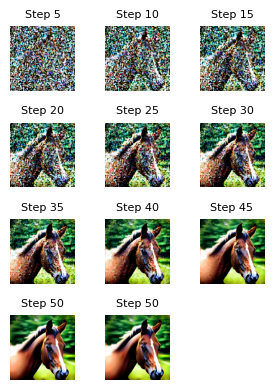

In [8]:
import torch
import matplotlib.pyplot as plt

generator = torch.Generator("cuda").manual_seed(123)
intermediate_images = []

def latents_callback(pipe, step_index, timestep, callback_kwargs):
    # Capture every 5 iterations
    if (step_index + 1) % 5  == 0:
        latents = callback_kwargs["latents"]
        with torch.no_grad():
            # Decode and process latent to PIL
            latents = 1 / 0.18215 * latents
            image = pipe.vae.decode(latents).sample
            image = (image / 2 + 0.5).clamp(0, 1)
            image = image.cpu().permute(0, 2, 3, 1).float().numpy()
            pil_image = pipe.numpy_to_pil(image)[0]
            intermediate_images.append((step_index + 1, pil_image))

    return callback_kwargs

# Run the generation
final_image = pipe(
    prompt="a horse staring directly at the camera",
    generator=generator,
    guidance_scale=30,
    num_inference_steps=50,
    callback_on_step_end=latents_callback,
    callback_on_step_end_tensor_inputs=['latents']
).images[0]

# Add the final result to our list
intermediate_images.append((50, final_image))

# --- Display in a Matrix ---
cols = 3
rows = (len(intermediate_images) + cols - 1) // cols
# figsize is (width, height) in inches.
# Since we want roughly 1x1 inch images, we scale by the grid size.
plt.figure(figsize=(cols, rows))

for i, (step, img) in enumerate(intermediate_images):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.title(f"Step {step}", fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()